<a href="https://colab.research.google.com/github/Paulo-vitorCS/DeepLearning/blob/main/Projeto_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projeto 10: Regressão Venda de Vídeo Games

###Etapa 01: Importação das Bibliotecas

In [1]:
import pandas as pd
from torch import nn, optim
import torch.nn.functional as F
import torch
import seaborn as sns
import matplotlib.pyplot as plt

###Etapa 02: Base de Dados

In [2]:
torch.manual_seed(123)

In [3]:
base = pd.read_csv('/content/games.csv')

In [4]:
base.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
base.shape

(16719, 16)

In [6]:
# Apagar o other_sales e o global_sales, developer
base = base.drop('Other_Sales', axis=1)
base = base.drop('Global_Sales', axis=1)
base = base.drop('Developer', axis=1)

In [7]:
base.shape

(16719, 13)

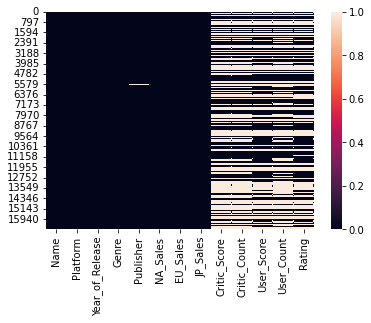

In [8]:
sns.heatmap(base.isnull());  # Visualizar dados faltantes

In [9]:
# Para fazer o tratamento dos dados, apagaremos os valores faltantes (não é uma boa alternativa)
base = base.dropna(axis=0)  # Acessa todos os valores faltantes e os apaga

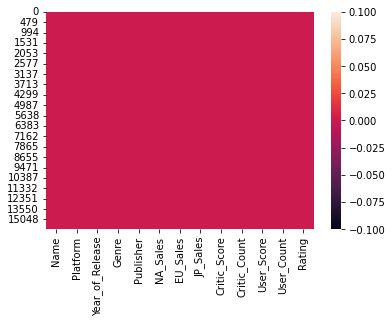

In [10]:
sns.heatmap(base.isnull());

In [11]:
base.shape  # Perdeu-se quase 10000 registros

(6825, 13)

In [12]:
base.loc[base['NA_Sales'] > 1]  # Busca as vendas em que o valor é maior que 1

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,76.0,51.0,8,322.0,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,82.0,73.0,8.3,709.0,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,80.0,73.0,8,192.0,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,89.0,65.0,8.5,431.0,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,58.0,41.0,6.6,129.0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872,NCAA Football 14,X360,2013.0,Sports,Electronic Arts,1.01,0.00,0.00,77.0,18.0,5.8,74.0,E
1877,NFL 2K1,DC,2000.0,Sports,Sega,1.02,0.05,0.00,97.0,22.0,6,47.0,E
1881,Madden NFL 2004,XB,2003.0,Sports,Electronic Arts,1.02,0.02,0.00,92.0,27.0,8.3,48.0,E
1889,NCAA Football 13,X360,2012.0,Action,Electronic Arts,1.02,0.00,0.00,76.0,20.0,5.5,65.0,E


In [13]:
# Filtro para buscar as vendas em que o valor é maior que 1
base = base.loc[base['NA_Sales'] > 1]

In [14]:
base.shape

(584, 13)

In [15]:
base.loc[base['EU_Sales'] > 1]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,76.0,51.0,8,322.0,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,82.0,73.0,8.3,709.0,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,80.0,73.0,8,192.0,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,89.0,65.0,8.5,431.0,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,58.0,41.0,6.6,129.0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,Medal of Honor,PS,1998.0,Shooter,Electronic Arts,1.44,1.09,0.00,92.0,17.0,8.6,80.0,T
573,Tom Clancy's Splinter Cell,PS2,2003.0,Action,Ubisoft,1.15,1.11,0.00,89.0,24.0,7.7,102.0,T
591,Mario Strikers Charged,Wii,2007.0,Sports,Nintendo,1.05,1.05,0.24,79.0,47.0,8,124.0,E10+
610,Crazy Taxi,PS2,2001.0,Racing,Acclaim Entertainment,1.13,1.12,0.06,80.0,15.0,7.9,46.0,T


In [16]:
base = base.loc[base['EU_Sales'] > 1]

In [17]:
base.shape

(258, 13)

In [18]:
base['Name'].value_counts()  # Mostra a quantidade de vezes em que o nome de um jogo aparece

Grand Theft Auto V                             4
Battlefield 4                                  3
Assassin's Creed IV: Black Flag                3
The Elder Scrolls V: Skyrim                    3
Call of Duty: Ghosts                           3
                                              ..
Far Cry 3                                      1
Saints Row: The Third                          1
Kinect Adventures!                             1
Mario Kart: Super Circuit                      1
LEGO Indiana Jones: The Original Adventures    1
Name: Name, Length: 223, dtype: int64

In [19]:
base = base.drop('Name', axis = 1)

In [20]:
base.shape

(258, 12)

In [21]:
previsores = base.iloc[:, [0,1,2,3,7,8,9,10,11]].values
vendas = base.iloc[:, 4:7].values

In [22]:
previsores

array([['Wii', 2006.0, 'Sports', ..., '8', 322.0, 'E'],
       ['Wii', 2008.0, 'Racing', ..., '8.3', 709.0, 'E'],
       ['Wii', 2009.0, 'Sports', ..., '8', 192.0, 'E'],
       ...,
       ['Wii', 2007.0, 'Sports', ..., '8', 124.0, 'E10+'],
       ['PS2', 2001.0, 'Racing', ..., '7.9', 46.0, 'T'],
       ['PS2', 2003.0, 'Simulation', ..., '8.4', 42.0, 'T']], dtype=object)

In [23]:
vendas

array([[4.136e+01, 2.896e+01, 3.770e+00],
       [1.568e+01, 1.276e+01, 3.790e+00],
       [1.561e+01, 1.093e+01, 3.280e+00],
       [1.128e+01, 9.140e+00, 6.500e+00],
       [1.396e+01, 9.180e+00, 2.930e+00],
       [1.444e+01, 6.940e+00, 4.700e+00],
       [9.710e+00, 7.470e+00, 4.130e+00],
       [8.920e+00, 8.030e+00, 3.600e+00],
       [1.500e+01, 4.890e+00, 2.400e-01],
       [9.010e+00, 8.490e+00, 2.530e+00],
       [7.020e+00, 9.090e+00, 9.800e-01],
       [4.740e+00, 9.200e+00, 4.160e+00],
       [9.660e+00, 5.140e+00, 6.000e-02],
       [8.410e+00, 5.490e+00, 4.700e-01],
       [3.430e+00, 5.350e+00, 5.320e+00],
       [6.850e+00, 5.090e+00, 1.870e+00],
       [9.040e+00, 4.240e+00, 1.300e-01],
       [9.700e+00, 3.680e+00, 1.100e-01],
       [4.990e+00, 5.730e+00, 6.500e-01],
       [8.250e+00, 4.240e+00, 7.000e-02],
       [8.520e+00, 3.590e+00, 8.000e-02],
       [5.540e+00, 5.730e+00, 4.900e-01],
       [6.990e+00, 4.510e+00, 3.000e-01],
       [6.620e+00, 2.550e+00, 2.66

In [24]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
onehotencoder = ColumnTransformer(transformers=[("OneHot", OneHotEncoder(), [0,2,3,8])], remainder = 'passthrough')
previsores = onehotencoder.fit_transform(previsores).toarray()

In [25]:
previsores.shape

(258, 61)

###Etapa 03: Construção do Modelo

In [26]:
# 61 -> 32 -> 32 -> 3
class regressor_torch(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense0 = nn.Linear(61, 32)
        self.dense1 = nn.Linear(32, 32)
        self.activation = nn.Sigmoid()
        self.output = nn.Linear(32, 3)
    
    def forward(self, X):  # Ligando as camadas
        X = self.dense0(X)
        X = self.activation(X)
        X = self.dense1(X)
        X = self.activation(X)
        X = self.output(X)
        
        return X

In [27]:
regressor = regressor_torch()

In [28]:
criterion = nn.MSELoss()
optimizer = optim.Adam(regressor.parameters())

In [29]:
type(previsores)

numpy.ndarray

In [30]:
previsores = torch.tensor(previsores, dtype=torch.float)
vendas = torch.tensor(vendas, dtype=torch.float)

In [31]:
type(previsores)

torch.Tensor

In [32]:
dataset = torch.utils.data.TensorDataset(previsores, vendas)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

###Etapa 04: Treinamento do Modelo

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [34]:
regressor.to(device)

regressor_torch(
  (dense0): Linear(in_features=61, out_features=32, bias=True)
  (dense1): Linear(in_features=32, out_features=32, bias=True)
  (activation): Sigmoid()
  (output): Linear(in_features=32, out_features=3, bias=True)
)

In [35]:
for epoch in range(2000):
    running_loss = 0.  # erro geral da rede
    running_mse_0 = 0.
    running_mse_1 = 0.
    running_mse_2 = 0.

    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = regressor.forward(inputs)

        # Erro para cada um dos atributos
        mse_0 = F.mse_loss(outputs[:, 0], labels[:, 0]).item()
        mse_1 = F.mse_loss(outputs[:, 1], labels[:, 1]).item()
        mse_2 = F.mse_loss(outputs[:, 2], labels[:, 2]).item()

        running_mse_0 += mse_0 * len(inputs)
        running_mse_1 += mse_1 * len(inputs)
        running_mse_2 += mse_2 * len(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss = loss.item()
        running_loss += loss * len(inputs)

        print('\rÉpoca {:4d} - Loop {:3d} de {:3d}: erro_0 {:6.4f} | erro_1 \ {:6.4f} | erro_2 {:6.4f} - custo {:6.4f}'.format(epoch + 1,
                                                                                                                         i+1,
                                                                                                                         len(train_loader),
                                                                                                                         mse_0,
                                                                                                                         mse_1,
                                                                                                                         mse_2,
                                                                                                                         loss), end = '\r')
        
    print('\rÉpoca {:4d} finalizada: erro_0 {:6.4f} | erro_1 {:6.4f} | \ erro_2 {:6.4f} - custo {:6.4f}     '.format(epoch + 1,
                                                                                                                 running_mse_0/len(dataset),
                                                                                                                 running_mse_1/len(dataset),
                                                                                                                 running_mse_2/len(dataset),
                                                                                                                 running_loss/len(dataset)))

Época    1 finalizada: erro_0 21.8178 | erro_1 13.7230 | \ erro_2 1.3285 - custo 12.2898     
Época    2 finalizada: erro_0 18.2655 | erro_1 10.4217 | \ erro_2 1.1840 - custo 9.9571     
Época    3 finalizada: erro_0 15.5166 | erro_1 8.2907 | \ erro_2 1.1737 - custo 8.3270     
Época    4 finalizada: erro_0 13.6868 | erro_1 6.9916 | \ erro_2 1.1744 - custo 7.2843     
Época    5 finalizada: erro_0 12.7259 | erro_1 6.3374 | \ erro_2 1.1725 - custo 6.7453     
Época    6 finalizada: erro_0 12.2527 | erro_1 6.0233 | \ erro_2 1.1762 - custo 6.4841     
Época    7 finalizada: erro_0 12.0585 | erro_1 5.9109 | \ erro_2 1.1721 - custo 6.3805     
Época    8 finalizada: erro_0 11.9757 | erro_1 5.8674 | \ erro_2 1.1703 - custo 6.3378     
Época    9 finalizada: erro_0 11.9579 | erro_1 5.8558 | \ erro_2 1.1777 - custo 6.3305     
Época   10 finalizada: erro_0 11.9362 | erro_1 5.8516 | \ erro_2 1.1754 - custo 6.3211     
Época   11 finalizada: erro_0 11.9393 | erro_1 5.8536 | \ erro_2 1.1735 - cus

###Etapa 05: Avaliação do Modelo

In [36]:
regressor.eval()

regressor_torch(
  (dense0): Linear(in_features=61, out_features=32, bias=True)
  (dense1): Linear(in_features=32, out_features=32, bias=True)
  (activation): Sigmoid()
  (output): Linear(in_features=32, out_features=3, bias=True)
)

In [37]:
previsores = previsores.to(device)
previsoes = regressor.forward(previsores)

In [38]:
previsoes

tensor([[ 4.6217,  3.4278,  1.2000],
        [ 2.8207,  2.1707,  0.6102],
        [ 4.6217,  3.4278,  1.2000],
        [ 4.6217,  3.4278,  1.2000],
        [ 4.6217,  3.4278,  1.2000],
        [ 2.8207,  2.1707,  0.6102],
        [ 4.6217,  3.4278,  1.2000],
        [ 4.6217,  3.4278,  1.2000],
        [ 4.6217,  3.4278,  1.2000],
        [ 3.6159,  2.6690,  0.8036],
        [ 3.4648,  2.1032,  0.0342],
        [ 4.6111,  3.4199,  1.1959],
        [ 3.4648,  2.1032,  0.0342],
        [ 2.8207,  2.1707,  0.6102],
        [ 2.4542,  1.7996,  0.3820],
        [ 4.6217,  3.4278,  1.2000],
        [ 3.0555,  2.1701, -0.0913],
        [ 3.4648,  2.1032,  0.0342],
        [ 2.8207,  2.1707,  0.6102],
        [ 3.4648,  2.1032,  0.0342],
        [ 3.4648,  2.1032,  0.0342],
        [ 3.4970,  2.3865,  0.0136],
        [ 2.8207,  2.1707,  0.6102],
        [ 3.4648,  2.1032,  0.0342],
        [ 2.8207,  2.1707,  0.6102],
        [ 2.8207,  2.1707,  0.6102],
        [ 3.4648,  2.1032,  0.0342],
 

In [39]:
previsoes = previsoes.cpu().detach().numpy()

In [40]:
previsoes

array([[ 4.6216974 ,  3.4278157 ,  1.2000123 ],
       [ 2.8206675 ,  2.1706533 ,  0.61015743],
       [ 4.6216974 ,  3.4278157 ,  1.2000123 ],
       [ 4.6216974 ,  3.4278157 ,  1.2000123 ],
       [ 4.6216974 ,  3.4278157 ,  1.2000123 ],
       [ 2.8206675 ,  2.1706533 ,  0.61015743],
       [ 4.6216726 ,  3.427799  ,  1.2000054 ],
       [ 4.6216974 ,  3.4278157 ,  1.2000123 ],
       [ 4.6216974 ,  3.4278157 ,  1.2000123 ],
       [ 3.6159453 ,  2.6690292 ,  0.80356693],
       [ 3.4648206 ,  2.1032317 ,  0.03423409],
       [ 4.6111455 ,  3.4199347 ,  1.1958685 ],
       [ 3.4648206 ,  2.1032317 ,  0.03423409],
       [ 2.8206675 ,  2.1706533 ,  0.61015743],
       [ 2.454214  ,  1.7996294 ,  0.38203004],
       [ 4.6216974 ,  3.4278157 ,  1.2000123 ],
       [ 3.0554936 ,  2.1700802 , -0.09133768],
       [ 3.4648206 ,  2.1032317 ,  0.03423409],
       [ 2.8206675 ,  2.1706533 ,  0.61015743],
       [ 3.4648206 ,  2.1032317 ,  0.03423409],
       [ 3.4648206 ,  2.1032317 ,  0.034

In [41]:
previsoes.mean(axis=0)

array([3.5254252, 2.5174155, 0.6113926], dtype=float32)

In [42]:
vendas.mean(axis=0)

tensor([3.2838, 2.3505, 0.5862])

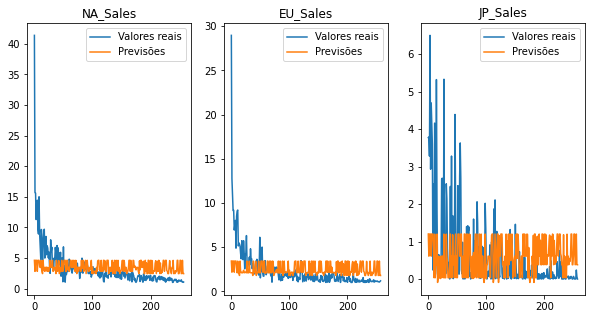

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(10,5))
for i in range(3):
    ax[i].plot(vendas[:, i])
    ax[i].plot(previsoes[:,i])
    ax[i].legend(['Valores reais', 'Previsões'])
    ax[i].set_title(base.columns[4+i])